In [3]:
!pip install kaggle


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os

# Path to the downloaded dataset zip file
dataset_zip = 'lung-cancer-histopathological-images.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('LungCancer')

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# Common settings
base_dir = 'LungCancer'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Increased to 0.2 for a clearer split
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use the same split as train_datagen
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Specify 'validation' subset
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1781788..1.0060229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1781788..1.0060229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016945882..0.96474594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016945882..0.96474594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18172805..1.0358425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18172805..1.0358425].


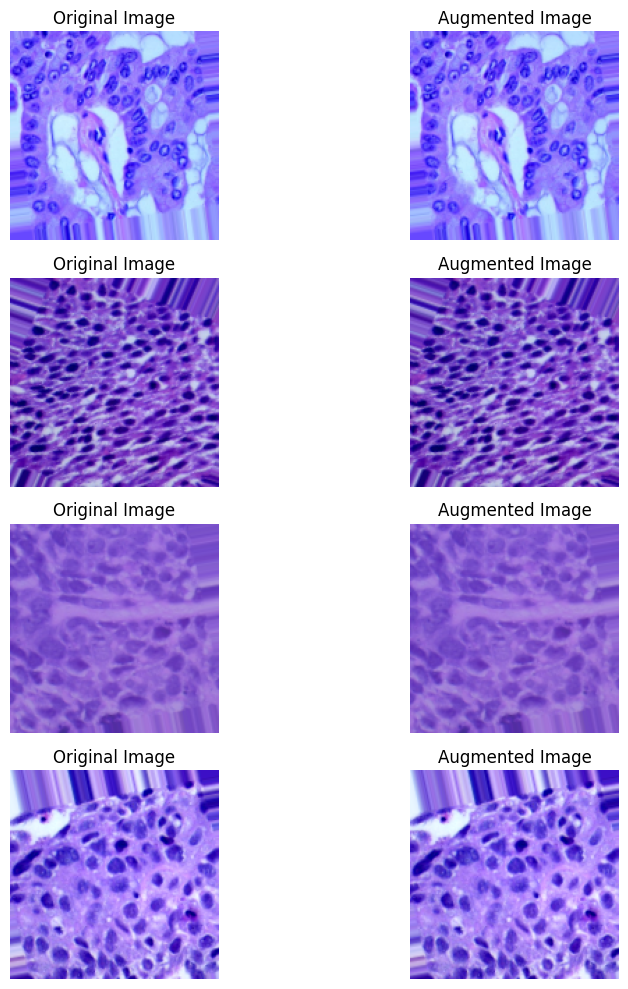

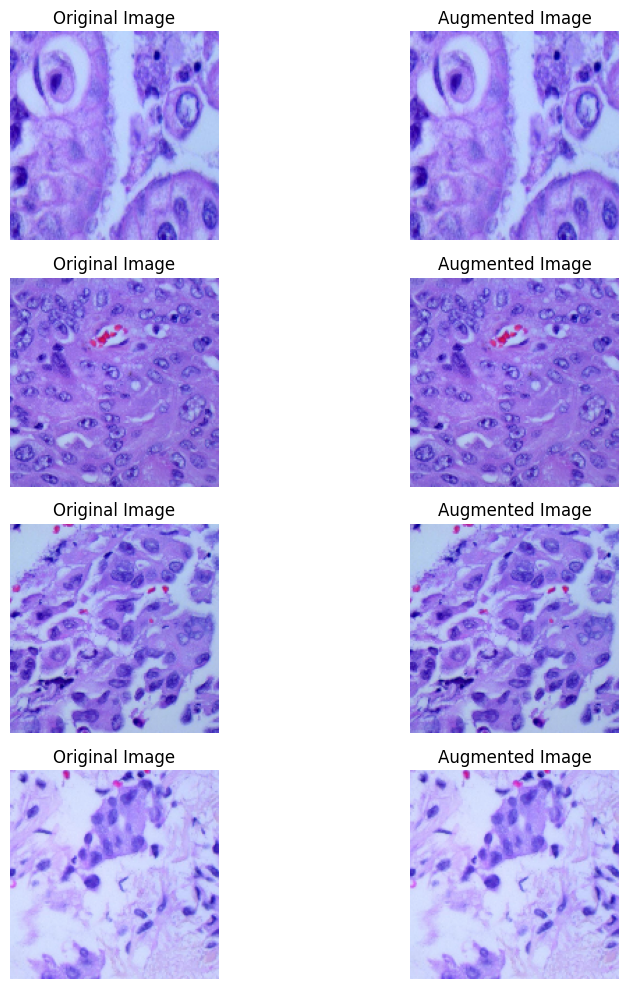

In [9]:
def display_images(generator, num_images=4):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images):
        img, label = next(generator)
        axs[2*i].imshow(img[0])
        axs[2*i].set_title('Original Image')
        axs[2*i].axis('off')

        axs[2*i+1].imshow(img[0])
        axs[2*i+1].set_title('Augmented Image')
        axs[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images for training data
display_images(train_generator)

# Display original and augmented images for validation data
display_images(validation_generator)

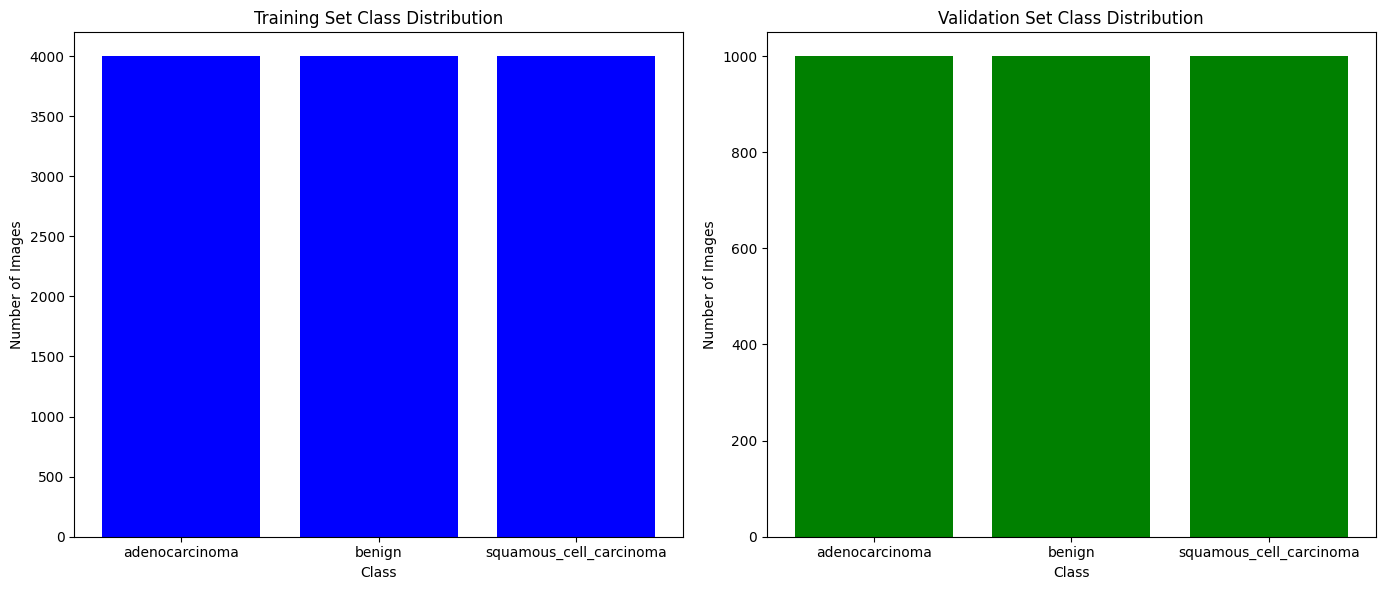

In [10]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [11]:
# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]


In [12]:
# Load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 26,212,227 (99.99 MB)

 Trainable params: 26,159,107 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/Users/kalariyatamanna/Documents/college/SEM5/SGP/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 4273s 11s/step - accuracy: 0.8717 - loss: 0.2949 - val_accuracy: 0.3333 - val_loss: 8.2708
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5321s 14s/step - accuracy: 0.9794 - loss: 0.0591 - val_accuracy: 0.7487 - val_loss: 0.6175
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4882s 13s/step - accuracy: 0.9850 - loss: 0.0454 - val_accuracy: 0.9587 - val_loss: 0.1185
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2595s 7s/step - accuracy: 0.9910 - loss: 0.0284 - val_accuracy: 0.9913 - val_loss: 0.0197
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21516s 58s/step - accuracy: 0.9917 - loss: 0.0237 - val_accuracy: 0.9780 - val_loss: 0.0944
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8025s 21s/step - accuracy: 0.9937 - loss: 0.0231 - val_accuracy: 0.9517 - val_loss: 0.1572
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11825s 32s/step - accuracy: 0.9935 - loss: 0.0215 - val_accuracy: 0.9790 - val_loss: 0.0924
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6404s 17s/step - accuracy: 0.9960 - loss: 0.0145 - va

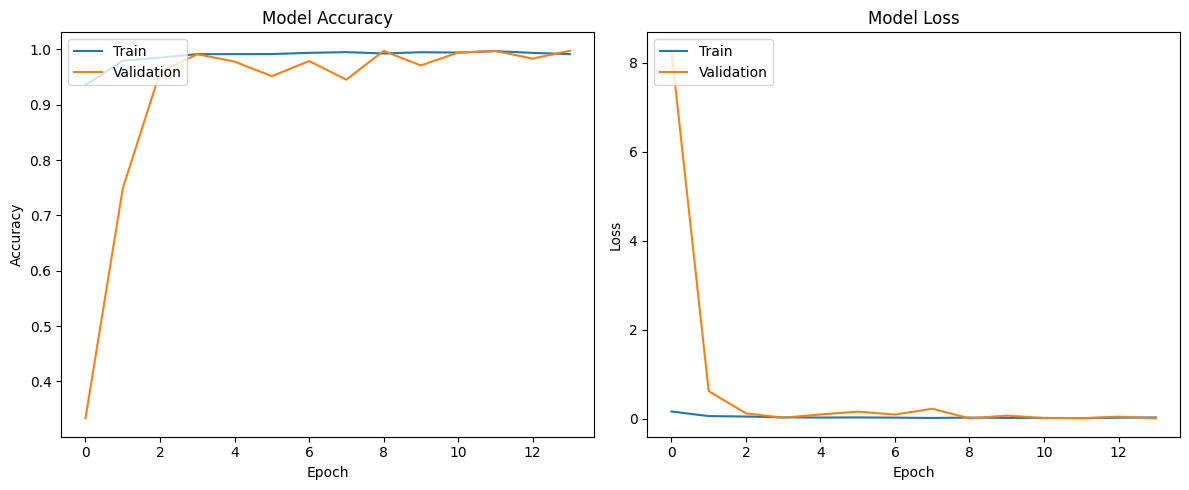

In [16]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [17]:
# Print final training and validation accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Final Training Accuracy: 0.9915
Final Validation Accuracy: 0.9977


In [18]:
def plot_predictions_with_confidence(model, validation_generator, num_images=10):
    # Get class names from the generator
    class_indices = validation_generator.class_indices
    class_names = list(class_indices.keys())
    
    # Extract a batch of validation data
    validation_generator.reset()
    X_val, y_val = next(validation_generator)
    for i in range(1, validation_generator.samples // validation_generator.batch_size):
        img, label = next(validation_generator)
        X_val = np.append(X_val, img, axis=0)
        y_val = np.append(y_val, label, axis=0)
    
    # Select random indices for plotting
    indices = random.sample(range(len(X_val)), num_images)
    selected_images = X_val[indices]
    selected_labels = y_val[indices]
    
    # Make predictions
    predictions = model.predict(selected_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Plot the images with predictions and confidence scores
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2x5 grid and larger figure size
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        axes[i].imshow(selected_images[i])
        axes[i].axis('off')
        true_label = class_names[np.argmax(selected_labels[i])]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%', color=color, fontsize=12)  # Larger font size
    
    plt.tight_layout()
    plt.show()



94/94 ━━━━━━━━━━━━━━━━━━━━ 616s 6s/step
Confusion Matrix:


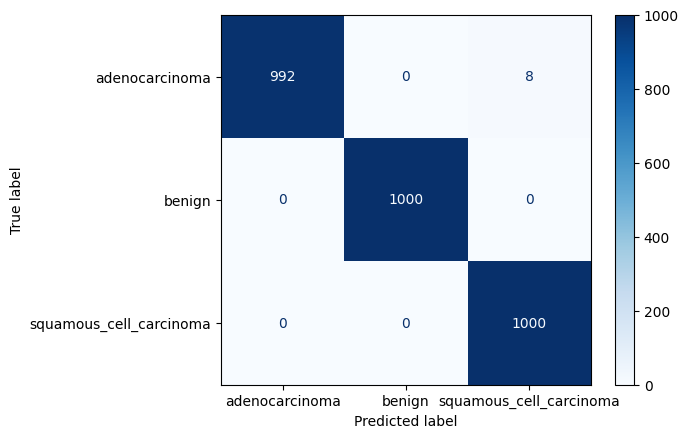

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Step 1: Make predictions on the validation data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels

# Step 2: Get the true labels from the validation data
y_true = validation_generator.classes  # True labels

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Print and visualize the confusion matrix
print("Confusion Matrix:")

# Optional: Visualize the confusion matrix
class_names = list(validation_generator.class_indices.keys())  # Class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)  # Adjust color map as needed
plt.show()


In [20]:
# Import necessary libraries
from sklearn.metrics import recall_score

# Assuming y_true and y_pred are available from the notebook
# y_true: actual labels
# y_pred: predicted labels

# Calculate recall
recall = recall_score(y_true, y_pred_classes, average='macro')  # For multi-class classification
print(f"Recall: {recall:.4f}")



Recall: 0.9973


In [21]:
# Save the trained model
try:
    model.save('lung_cancer_resnet.h5')
    print("Model successfully saved as 'lung_cancer_resnet.h5'")
    
    # Verify the file was created
    if os.path.exists('lung_cancer_resnet.h5'):
        print(f"Verified: Model file exists at {os.path.abspath('lung_cancer_resnet.h5')}")
        print(f"File size: {os.path.getsize('lung_cancer_resnet.h5') / (1024*1024):.2f} MB")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved as 'lung_cancer_resnet.h5'
Verified: Model file exists at /Users/kalariyatamanna/Documents/college/SEM5/SGP/python/Cancer/lung_cancer_resnet.h5
File size: 300.33 MB


In [22]:
from sklearn.metrics import precision_score
# Calculate and print precision
precision = precision_score(y_true, y_pred_classes, average='macro')
print(f"Precision: {precision:.4f}")

Precision: 0.9974
